In [3]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
# get train & test csv files as a DataFrame
train_url = 'https://raw.githubusercontent.com/jayantabh/kaggle-titanic/master/input/train.csv'
test_url = 'https://raw.githubusercontent.com/jayantabh/kaggle-titanic/master/input/test.csv'
train_df = pd.read_table(train_url, sep=',', encoding='latin-1')
test_df = pd.read_table(test_url, sep=',', encoding='latin-1')

In [5]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [7]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
train_df = train_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df = test_df.drop(['Name','Ticket'], axis=1)

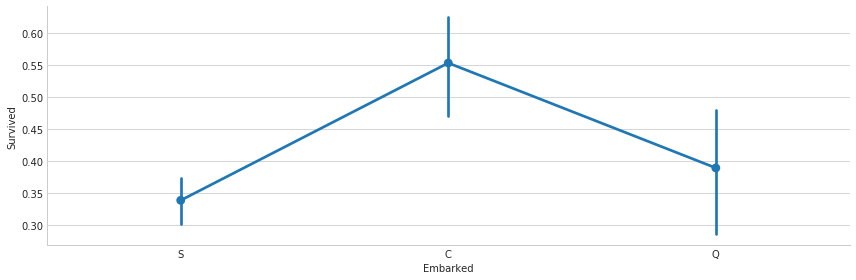

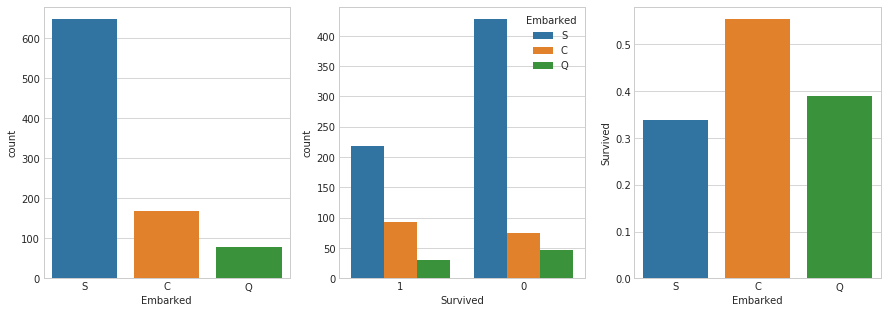

In [8]:
# Embarked

# only in train_df, fill the two missing values with the most occurred value, which is "S".
train_df["Embarked"] = train_df["Embarked"].fillna("S")

# plot
sns.factorplot('Embarked','Survived', data=train_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# sns.factorplot('Embarked',data=train_df,kind='count',order=['S','C','Q'],ax=axis1)
# sns.factorplot('Survived',hue="Embarked",data=train_df,kind='count',order=[1,0],ax=axis2)
sns.countplot(x='Embarked', data=train_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = train_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_train  = pd.get_dummies(train_df['Embarked'])
embark_dummies_train.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

train_df = train_df.join(embark_dummies_train)
test_df    = test_df.join(embark_dummies_test)

train_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

In [9]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q
0,0,3,male,22.0,1,0,7.2500,NaN,0,0
1,1,1,female,38.0,1,0,71.2833,C85,1,0
2,1,3,female,26.0,0,0,7.9250,NaN,0,0
3,1,1,female,35.0,1,0,53.1000,C123,0,0
4,0,3,male,35.0,0,0,8.0500,NaN,0,0


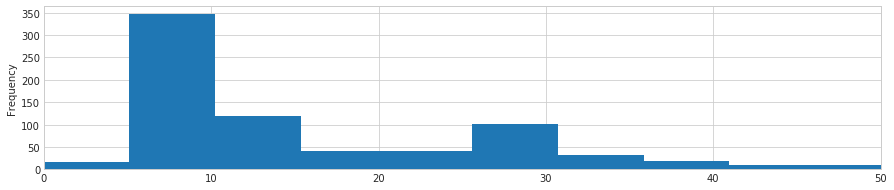

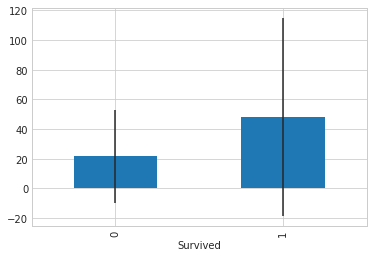

In [11]:
# Fare

# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
train_df['Fare'] = train_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = train_df["Fare"][train_df["Survived"] == 0]
fare_survived     = train_df["Fare"][train_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
average_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
train_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

average_fare.index.names = std_fare.index.names = ["Survived"]
average_fare.plot(yerr=std_fare,kind='bar',legend=False)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


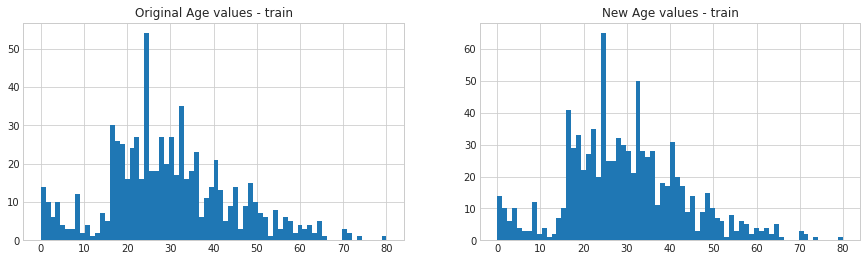

In [12]:
# Age 

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - train')
axis2.set_title('New Age values - train')

# axis3.set_title('Original Age values - Test')
# axis4.set_title('New Age values - Test')

# get average, std, and number of NaN values in train_df
average_age_train   = train_df["Age"].mean()
std_age_train       = train_df["Age"].std()
count_nan_age_train = train_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_train - std_age_train, average_age_train + std_age_train, size = count_nan_age_train)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# plot original Age values
# NOTE: drop all null values, and convert to int
train_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
# test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
train_df["Age"][np.isnan(train_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
train_df['Age'] = train_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)
        
# plot new Age Values
train_df['Age'].hist(bins=70, ax=axis2)
# test_df['Age'].hist(bins=70, ax=axis4)

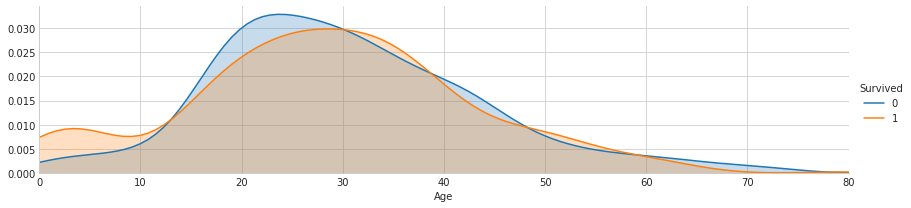

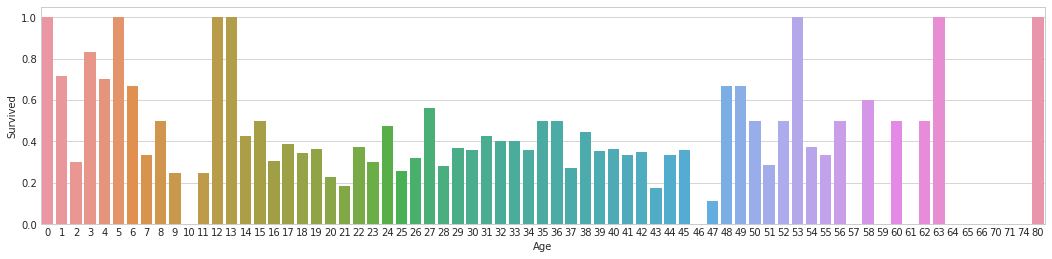

In [13]:
# continue with plot Age column

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = train_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [21]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
train_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

In [25]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
train_df['Family'] =  train_df["Parch"] + train_df["SibSp"]
train_df['Family'].loc[train_df['Family'] > 0] = 1
train_df['Family'].loc[train_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop Parch & SibSp
train_df = train_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=train_df,kind='count',ax=axis1)
sns.countplot(x='Family', data=train_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = train_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

KeyError: 'Parch'

[Text(0,0,'With Family'), Text(0,0,'Alone')]

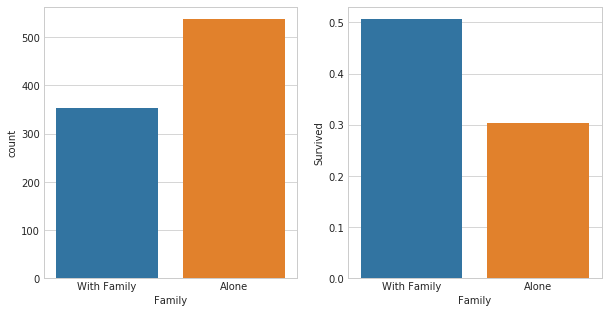

In [28]:
# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=train_df,kind='count',ax=axis1)
sns.countplot(x='Family', data=train_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = train_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

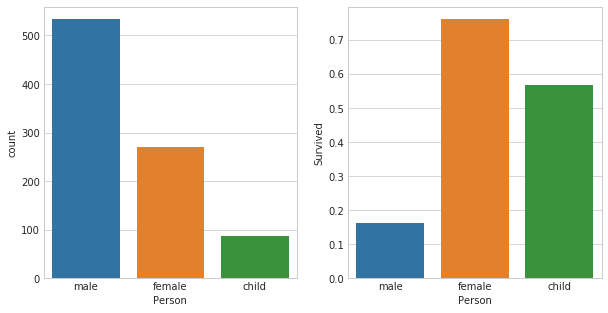

In [29]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
train_df['Person'] = train_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person'] = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
train_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_train  = pd.get_dummies(train_df['Person'])
person_dummies_train.columns = ['Child','Female','Male']
person_dummies_train.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

train_df = train_df.join(person_dummies_train)
test_df = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=train_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=train_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = train_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

train_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

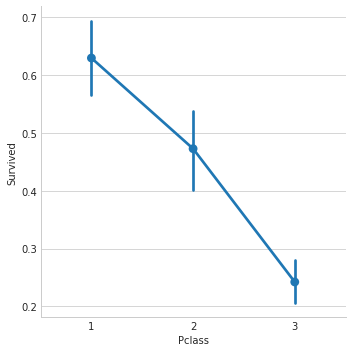

In [30]:
# Pclass

# sns.factorplot('Pclass',data=train_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=train_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_train  = pd.get_dummies(train_df['Pclass'])
pclass_dummies_train.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_train.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

train_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

train_df = train_df.join(pclass_dummies_train)
test_df    = test_df.join(pclass_dummies_test)

In [31]:
# define training and testing sets

X_train = train_df.drop("Survived",axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [32]:
# Logistic Regression

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

0.813692480359147

In [39]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.9663299663299664

In [40]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Age,-0.025862
1,Fare,0.000949
2,C,0.593531
3,Q,0.254755
4,Family,-0.225299
5,Child,1.679221
6,Female,2.771983
7,Class_1,1.993644
8,Class_2,1.118253


In [41]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)